In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
import requests
import zipfile
from pathlib import Path

In [4]:
data_path = Path('data')
image_path = data_path / 'flowers'
zip_path = Path('/content/drive/MyDrive/flowers_prepared.zip')

In [ ]:
if data_path.is_dir():
  print(f"{data_path} directory exists, skipping download")
else:
  print(f"{data_path} directory not exists, creating...")
  data_path.mkdir(parents=True, exist_ok=True)

data directory exists, skipping download


In [ ]:
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping download")
else:
  print(f"{image_path} directory not exists, creating...")
  print('check if has already extract zip file')
  if zip_path.is_file():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      print("Unzipping...")
      zip_ref.extractall(data_path)
      zip_ref.close()
      print("Success...")
  else:
    print('need to upload zip file')

data/flowers directory not exists, creating...
check if has already extract zip file
Unzipping...
Success...


In [ ]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(Path('data') / 'flowers_prepared' / 'train', transform = transform)
test_dataset  = datasets.ImageFolder(Path('data') / 'flowers_prepared' / 'test', transform = transform)

train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# choose a pre-trained model
model = models.resnet50(pretrained=True)
num_ftrs= model.fc.in_features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [ ]:
# choose torch.nn that better suit the task
model.fc = torch.nn.Linear(num_ftrs, 5)

In [ ]:
# enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device)

In [ ]:
# set optimizer and loss_fn
loss_fn   = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
train_losses, test_losses = [], []

In [ ]:
def train_loop(data_loader):
  model.train()
  running_loss = 0
  for images, labels in data_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss


def test_loop(data_loader):
  model.eval()
  test_loss = 0
  with torch.inference_mode():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      test_loss += loss.item()
  return test_loss

In [ ]:
for epoch in range(num_epochs):
  train_loss = train_loop(train_loader)
  train_losses.append(train_loss / len(train_loader))
  print(f"For epoch: {epoch}, train loss is {train_loss}")

  test_loss = test_loop(test_loader)
  test_losses.append(test_loss / len(test_loader))
  print(f"For epoch: {epoch}, test loss is {test_loss}")

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")


For epoch: 0, train loss is 100.14829552173615
For epoch: 0, test loss is 47.52026671171188
Epoch 1/10, Train Loss: 1.0219213828748586, Test Loss: 1.2505333345187337
For epoch: 1, train loss is 81.44533967971802
For epoch: 1, test loss is 35.75418835878372
Epoch 2/10, Train Loss: 0.8310748946910002, Test Loss: 0.9408996936522032
For epoch: 2, train loss is 68.28782293200493
For epoch: 2, test loss is 60.0946683883667
Epoch 3/10, Train Loss: 0.6968145197143361, Test Loss: 1.5814386417991237
For epoch: 3, train loss is 64.7480802834034
For epoch: 3, test loss is 47.31631475687027
Epoch 4/10, Train Loss: 0.6606946967694224, Test Loss: 1.2451661778123755
For epoch: 4, train loss is 60.91718763113022
For epoch: 4, test loss is 64.78478720784187
Epoch 5/10, Train Loss: 0.6216039554196962, Test Loss: 1.7048628212589967
For epoch: 5, train loss is 55.39134472608566
For epoch: 5, test loss is 28.87970158457756
Epoch 6/10, Train Loss: 0.5652178033274047, Test Loss: 0.7599921469625673
For epoch: 

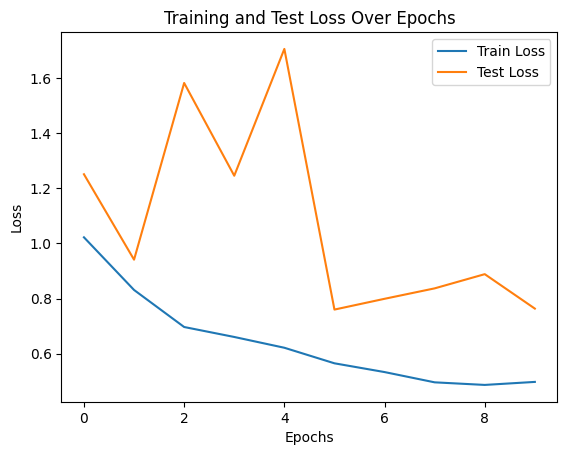

In [ ]:
# Visualization
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
def process_image(image_path):
  transformation = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  image = Image.open(image_path)
  image = image.convert('RGB')
  image_tensor = transformation(image).unsqueeze(0) # add batch dimension

  return image_tensor.to(device)

In [ ]:
def make_prediction(image_path):
  image_tensor = process_image(image_path)
  with torch.inference_mode():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs.data, 1)

  predicted_class = class_names[predicted.item()]

  return predicted_class

In [ ]:
rose_img_path = Path('/content/data/flowers_prepared/rose1.jpg')
print(make_prediction(rose_img_path))

rose


In [ ]:
rose_img_path = Path('/content/data/flowers_prepared/daisy1.jpg')
print(make_prediction(rose_img_path))

daisy
